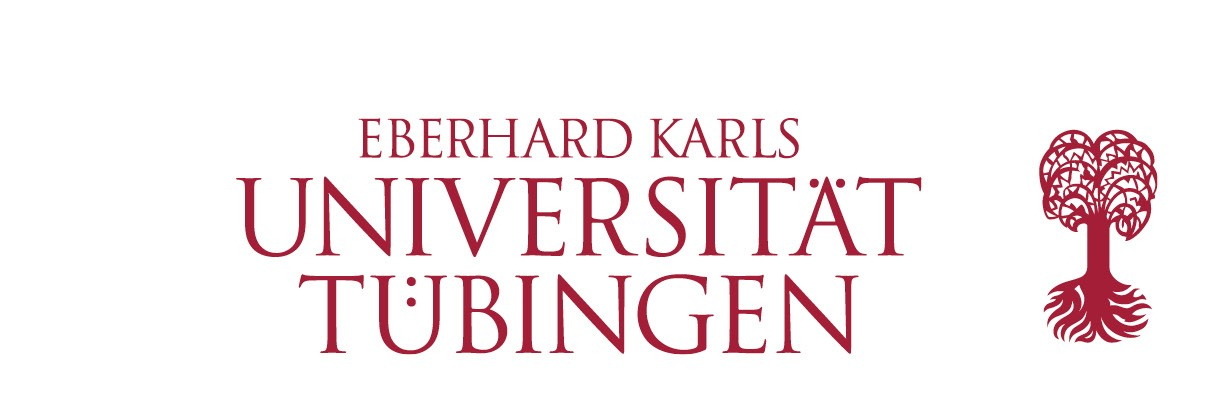

# **Computational Immunomics 2023**

Interfakultäres Institut für Biomedizinische Informatik (IBMI)

Prof. Dr. Oliver Kohlbacher

Tutors:
Alexander Röhl, Matteo Pilz

ci-ss23@informatik.uni-tuebingen.de

# **INFORMATION**

You should work in groups of 3 to 4 on the project, please write your names here:
1. Micha Fauth
2. Maximilian Wilhelm
3. Vishwa Patel
4. Kushal Chakraborty

You are allowed to write in german or english.
Your hand in should be zipped and the archive should follow the naming convention: 
project_\<name_1\>_\<name_2\>_\<name_3\>_\<name_4\>.zip\
Example: project_weber_mueller_muster_sommer.zip

Finally, upload your zip file containing all important files to ILIAS.

Tip: You can use some LaTex commands (rendered with MathJax) in math mode: $\alpha$
# **Project (100P + 5BP) - Hand In: Thursday July 20, 11:55 pm**

This project applies the practical knowledge you gained on machine learning during the lecture and the assignments of this course.
Your task is to implement a MHC I-binding predictor with a prediction as accurate as possible. You may thereby use any method, model, or strategy, which you implemented using any python library.
However, you are not allowed to simply load in and use an existing predictor. Copying the code from one is also not allowed and will, without citation, be counted as plagiarism. You are free to **adopt** existing implementations (please cite accordingly) and orientate yourself on published models regarding structure and parameters.

Feel free to also make use of the following potential work plan.

## <h2><center>Dates \& Potential Work Plan</center></h2>

| **Date**         | **Task**                                                                                                          |
|------------------|-------------------------------------------------------------------------------------------------------------------|
| June 13 - Week 1 | **Project handout**, research / familiarize yourself with the Python libraries                                    |
| June 20          | **[Group assignment](#group_assignment) 11:55 pm**, Assign yourself to one of the groups in ILIAS                 |
| June 22 - Week 2 | Choose an appropriate [encoding](#encoding)                                                                       |
| June 29 - Week 3 | Create [model](#model) drafts                                                                                     |
| July 06 - Week 4 | [Optimize](#optimization) your model by using a cross-validation pipeline                                         |
| July 13 - Week 5 | Finish the [optimization](#optimization), write the [prediction output](#output) function & write-up your project |
| July 20 - Week 6 | **Project handin 11:55 pm**, prepare presentation                                                                 |
| July 27          | **[Project presentation](#presentation)**                                                                         |
| August 03        | **Written exam**                                                                                                  |

<a id='group_assignment'></a>

## **Group Assignment - Tuesday June 20, 11:55 pm**
Assign yourself to one of the groups in the Computational Immunomics workspace in ILIAS under */Exercises/Project*. Make sure you and the rest of your group assign yourself to the same group. Joining and leaving a group in ILIAS is possible until Tuesday June 20 11:55 pm.

---
## **1. Input**
You are given a dataset with labeled datapoints as training data in `ci_project_data.csv`. The dataset contains four columns: `sequence`, `label`, `length` and `affinity`. The labels are `0 == non binder` and `1 == binder` (classification), the `affinity` is the binding affinity from 0-1, which you may use as an alternative (regression). Use this data wisely in order to fulfill the requirements of the project. At the end, make sure that your selected model is trained on the full dataset \*, before you use it for prediction.

### **Bonus (5BP)**
\* The dataset does not only contain peptides with length 9, but also shorter and longer ones. Find a suitable way to encode these peptides (in [2. Encoding](#encoding)) and use them in your training, too. If you don't want to do this task, you can simply filter out all peptides that do not have length 9 (the remaining number of sequences should be 7176).

In [24]:
# imports
import pandas as pd
import numpy as np
from IPython.display import Image
import os, sys, math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import *
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(1)


In [25]:
project_data = pd.read_csv('ci_project_train.csv')

# project_data = project_data.loc[project_data['length'] == 9]

# For regression model only (comment out for classification)
# Here we modifing the affinity values if the are a fp or fn
#project_data['affinity'] = np.where((project_data['affinity'] < 0.5) & (project_data['label'] != 0),
#                                    np.random.uniform(0.5, 1, size=len(project_data)), project_data['affinity'])
#project_data['affinity'] = np.where((project_data['affinity'] >= 0.5) & (project_data['label'] != 1),
#                                    np.random.uniform(0, 0.5, size=len(project_data)), project_data['affinity'])



project_data

,sequence,label,length,affinity
0,SVFNSLYA,0,8,0.419718
1,YLIRALTL,0,8,0.407692
2,FLTGYLQL,0,8,0.401746
3,ALQLLLEV,0,8,0.399727
4,VLFQNWGI,0,8,0.376714
...,...,...,...,...
9649,ALTSLGLLYT,1,10,0.448816
9650,ITLLCLIPTV,1,10,0.437257
9651,RLHKECLLRL,1,10,0.436015
9652,AITLVVISVI,1,10,0.426713


---
CI_SS20_02D: "The binding groove is large enough to fit peptides of length 8 – 10 amino acids"

The following image shows that the most important binding positions are P2 and P9.
But P3, P6 and P7 are also bond by binding grooves.

The following 3 images were taken from the lecture slides.

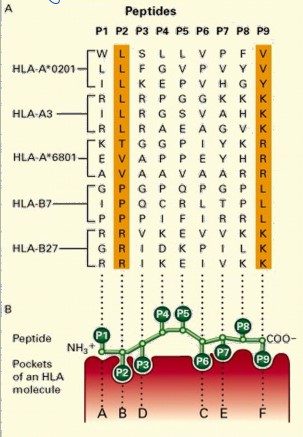

In [26]:
Image(filename='images/MHC_1_Binding.jpg')

The following image shows that MHC-I still binds peptides that are longer than 10 amino acids.

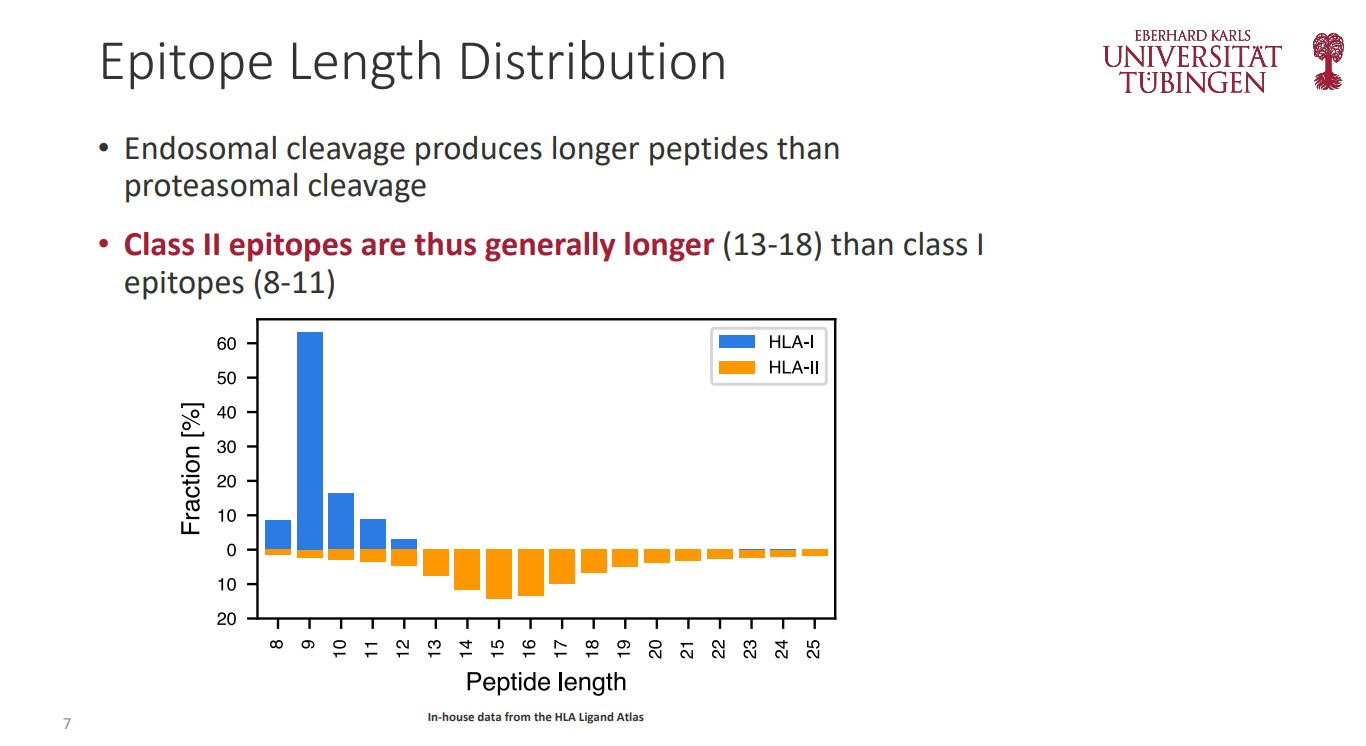

In [27]:
Image(filename='images/Epitope Length Distribution.jpg')

Add Padding to peptides of length 8 (at the beginning) and shorten peptides bigger lengths.
The following image shows how to shorten longer peptides.
They bulge in the middle leaving every important binding position.

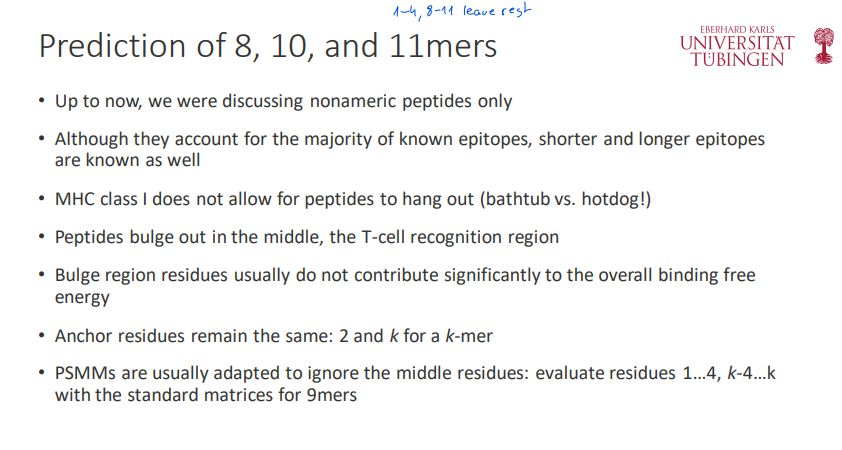

In [28]:
Image(filename='images/bulge-slide.jpg')

In [29]:
project_data = project_data[(project_data['length'] >= 8)].reset_index(drop=True)
# project_data = project_data[(project_data['length'] >= 8) & (project_data['length'] <= 11)].reset_index(drop=True)
for index, row in project_data.iterrows():
    sequence_l = row['sequence']
    if len(sequence_l) > 9:
        # buldge in the middle -> near zero impact on the affinity as binder
        project_data.at[index, 'sequence'] = sequence_l[:4] + sequence_l[-5:]

# length of df shoes the original length even though the sequence is already shortened
project_data

,sequence,label,length,affinity
0,SVFNSLYA,0,8,0.419718
1,YLIRALTL,0,8,0.407692
2,FLTGYLQL,0,8,0.401746
3,ALQLLLEV,0,8,0.399727
4,VLFQNWGI,0,8,0.376714
...,...,...,...,...
9649,ALTSGLLYT,1,10,0.448816
9650,ITLLLIPTV,1,10,0.437257
9651,RLHKCLLRL,1,10,0.436015
9652,AITLVISVI,1,10,0.426713


Padding for peptides of length 8 added through Encoding Methods. Because Padding needs to be encoded as well.

<a id='encoding'></a>

---
## **2. Encoding**
Explain how you encode your data, so that the model is able to return meaningful predictions. If you use an encoding from an existing source, which we encourage, make sure to properly cite it. We also encourage you to prepare multiple different encodings and compare their results later.

We tried different encodings: One-Hot- , Blomap-, Integer- and Random Encoding.
In every Encoding type we used the '0' as padding for peptides of length 8.
The Encoding types are separable into 3 categories:

Predefined value: OHE and Integer Encoding
    - every amino acid gets mapped to a specific predefined value (Code Block below '# Encoding Data')
Random value: Random Encoding
    - every amino acid gets a random value.
    - we did not except anything out of it but wanted to see the difference.
Biochemical Properties: Blomap Encoding
    - the values (blomap_matrix) are calculated based on the BLOSUM62 substitution matrix using a naive Bayes classifier
    - the authors introduced this specific encoding for cleavage site prediction, which is not exactly our goal here but it was interesting to see the difference this encoding type does

In [30]:
# Encoding Data

aa_mapping = {
    'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4,
    'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9,
    'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
    'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19
}

# Source: MAETSCHKE, S., TOWSEY, M., & BODÉN, M. (2005). BLOMAP: AN ENCODING OF AMINO ACIDS WHICH IMPROVES SIGNAL PEPTIDE CLEAVAGE SITE PREDICTION. In Proceedings of the 3rd Asia-Pacific Bioinformatics Conference. 3rd Asia-Pacific Bioinformatics Conference. PUBLISHED BY IMPERIAL COLLEGE PRESS AND DISTRIBUTED BY WORLD SCIENTIFIC PUBLISHING CO. https://doi.org/10.1142/9781860947322_0014
# Table 1: by Stefan Renard Maetschke
# Dimension = biochemical properties or features of amino acids
blomap_matrix = pd.DataFrame({
    'A': [-.57, .39, -.96, -.61, -.69],
    'C': [.07, 2.04, .65, -1.13, -.39],
    'D': [-1.62, -0.52, -0.67, 1.02, 1.47],
    'E': [-0.64, -1.59, -.39, .69, 1.04],
    'F': [1.87, 1.04, 1.28, -.61, -.16],
    'G': [-.90, .87, -0.36, 1.08, 1.95],
    'H': [0.73, -0.67, -0.42, 1.13, 0.99],
    'I': [0.59, .79, 1.44, -1.90, -.93],
    'K': [-.64, -1.19, -.65, .68, -.13],
    'L': [.65, .84, 1.25, -.99, -1.90],
    'M': [.76, .05, .06, -.62, -1.59],
    'N': [-.70, -.63, -1.47, 1.02, 1.06],
    'P': [-1.82, -0.63, .32, .03, .68],
    'Q': [-.05, -1.50, -.67, .49, .21],
    'R': [-.40, -0.83, -0.61, 1.26, -0.28],
    'S': [-.39, -.27, -1.51, -.25, .31],
    'T': [-.04, -.30, -.82, -1.02, -.04],
    'V': [-.02, 0.30, .97, -1.55, -1.16],
    'W': [1.38, 1.69, 1.91, 1.07, -.05],
    'Y': [-.02, .30, .97, -1.55, -1.16]
})

In [31]:
# One-Hot-Encoding
# Functions
def encode_aa(aa):
    encoded_vector = [0] * 20
    encoded_vector[aa_mapping[aa]] = 1

    return encoded_vector

def one_hot_encode(sequence):
    encoded_sequence = np.array([], dtype=int)
    if len(sequence) == 8:
        encoded_sequence = np.append(encoded_sequence, np.zeros(20, dtype=int))

    for aa in sequence:
        encoded_sequence = np.append(encoded_sequence, encode_aa(aa))

    return encoded_sequence.astype(int)

def ohe_encode_df(df):
    encoded_sequences_f = []
    for sequence in df:
        encoded_sequences_f.append(one_hot_encode(sequence))
    return pd.DataFrame({"encoded_sequences": encoded_sequences_f}, columns=['encoded_sequences'])



In [32]:
# One-Hot-Encoding
# Data Encoding
ohe_encoded_sequences = ohe_encode_df(project_data['sequence'])
ohe_encoded_df = pd.concat([ohe_encoded_sequences, project_data], axis=1)
ohe_encoded_df

,encoded_sequences,sequence,label,length,affinity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SVFNSLYA,0,8,0.419718
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",YLIRALTL,0,8,0.407692
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",FLTGYLQL,0,8,0.401746
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ALQLLLEV,0,8,0.399727
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",VLFQNWGI,0,8,0.376714
...,...,...,...,...,...
9649,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ALTSGLLYT,1,10,0.448816
9650,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",ITLLLIPTV,1,10,0.437257
9651,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",RLHKCLLRL,1,10,0.436015
9652,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",AITLVISVI,1,10,0.426713


In [33]:
# Integer Encoding
# Functions
def integer_encode(sequence):
    encoded_sequence = [aa_mapping[aa] + 1 for aa in sequence]
    if len(sequence) == 8:
        encoded_sequence = np.append([0], encoded_sequence)
    return encoded_sequence

def int_encode_df(df):
    encoded_sequences_f = []
    for sequence in df:
        encoded_sequences_f.append(integer_encode(sequence))
    return pd.DataFrame({"encoded_sequences": encoded_sequences_f}, columns=['encoded_sequences'])


In [34]:
# Integer Encoding
# Data Encoding
int_encoded_sequences = int_encode_df(project_data['sequence'])
int_encoded_df = pd.concat([int_encoded_sequences, project_data], axis=1)
int_encoded_df

,encoded_sequences,sequence,label,length,affinity
0,"[0, 16, 18, 5, 12, 16, 10, 20, 1]",SVFNSLYA,0,8,0.419718
1,"[0, 20, 10, 8, 15, 1, 10, 17, 10]",YLIRALTL,0,8,0.407692
2,"[0, 5, 10, 17, 6, 20, 10, 14, 10]",FLTGYLQL,0,8,0.401746
3,"[0, 1, 10, 14, 10, 10, 10, 4, 18]",ALQLLLEV,0,8,0.399727
4,"[0, 18, 10, 5, 14, 12, 19, 6, 8]",VLFQNWGI,0,8,0.376714
...,...,...,...,...,...
9649,"[1, 10, 17, 16, 6, 10, 10, 20, 17]",ALTSGLLYT,1,10,0.448816
9650,"[8, 17, 10, 10, 10, 8, 13, 17, 18]",ITLLLIPTV,1,10,0.437257
9651,"[15, 10, 7, 9, 2, 10, 10, 15, 10]",RLHKCLLRL,1,10,0.436015
9652,"[1, 8, 17, 10, 18, 8, 16, 18, 8]",AITLVISVI,1,10,0.426713


In [35]:
# Random Encoding
# Functions

def random_encode(sequence):
    encoded_sequence = [np.random.randint(1, 21) for _ in sequence]
    if len(sequence) == 8:
        encoded_sequence = [0] + encoded_sequence
    return encoded_sequence

def random_encode_df(df):
    encoded_sequences_f = []
    for sequence in df:
        encoded_sequences_f.append(random_encode(sequence))
    return pd.DataFrame({"encoded_sequences": encoded_sequences_f}, columns=['encoded_sequences'])

In [36]:
# Random Encoding
# Data Encoding
random_encoded_sequences = random_encode_df(project_data['sequence'])
random_encoded_df = pd.concat([random_encoded_sequences, project_data], axis=1)
random_encoded_df

,encoded_sequences,sequence,label,length,affinity
0,"[0, 6, 12, 13, 9, 10, 12, 6, 16]",SVFNSLYA,0,8,0.419718
1,"[0, 1, 17, 2, 13, 8, 14, 7, 19]",YLIRALTL,0,8,0.407692
2,"[0, 6, 19, 12, 11, 15, 19, 5, 10]",FLTGYLQL,0,8,0.401746
3,"[0, 18, 1, 14, 10, 10, 8, 2, 1]",ALQLLLEV,0,8,0.399727
4,"[0, 18, 9, 14, 20, 16, 11, 9, 8]",VLFQNWGI,0,8,0.376714
...,...,...,...,...,...
9649,"[8, 12, 10, 7, 1, 2, 18, 13, 19]",ALTSGLLYT,1,10,0.448816
9650,"[4, 15, 16, 12, 4, 19, 9, 6, 11]",ITLLLIPTV,1,10,0.437257
9651,"[20, 12, 7, 13, 8, 10, 17, 19, 19]",RLHKCLLRL,1,10,0.436015
9652,"[4, 11, 4, 20, 11, 18, 13, 6, 9]",AITLVISVI,1,10,0.426713


In [37]:
# Blomap Encoding (= Block Mapping and Neural Network Prediction)
# Functions

def blomap_encode(sequence):
    encoded_sequence = []
    if len(sequence) == 8:
        encoded_sequence.extend([0.0] * 5)
    for aa in sequence:
        if aa in blomap_matrix.columns:
            encoded_sequence.extend(blomap_matrix[aa])
    return encoded_sequence

def blomap_encode_df(df):
    encoded_sequences_f = []
    for sequence in df:
        encoded_sequences_f.append(blomap_encode(sequence))
    return pd.DataFrame({"encoded_sequences": encoded_sequences_f}, columns=['encoded_sequences'])

In [38]:
# Blomap Encoding
# Data Encoding
blomap_encoded_sequences = blomap_encode_df(project_data['sequence'])
blomap_encoded_df = pd.concat([blomap_encoded_sequences, project_data], axis=1)
blomap_encoded_df

,encoded_sequences,sequence,label,length,affinity
0,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.39, -0.27, -1.51,...",SVFNSLYA,0,8,0.419718
1,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.3, 0.97, -1...",YLIRALTL,0,8,0.407692
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.87, 1.04, 1.28, -0...",FLTGYLQL,0,8,0.401746
3,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.57, 0.39, -0.96, ...",ALQLLLEV,0,8,0.399727
4,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.02, 0.3, 0.97, -1...",VLFQNWGI,0,8,0.376714
...,...,...,...,...,...
9649,"[-0.57, 0.39, -0.96, -0.61, -0.69, 0.65, 0.84,...",ALTSGLLYT,1,10,0.448816
9650,"[0.59, 0.79, 1.44, -1.9, -0.93, -0.04, -0.3, -...",ITLLLIPTV,1,10,0.437257
9651,"[-0.4, -0.83, -0.61, 1.26, -0.28, 0.65, 0.84, ...",RLHKCLLRL,1,10,0.436015
9652,"[-0.57, 0.39, -0.96, -0.61, -0.69, 0.59, 0.79,...",AITLVISVI,1,10,0.426713


<a id='model'></a>

---
## **3. Machine Learning Model**
Select at least one machine learning algorithm, which you'd like to apply your following tests on. Explain why you chose those algorithms. Note: It may be beneficial to set up multiple different models and test their performance for your task, even if you end up using only one at the end.

...

In this Section we tried multiple different models and machine learning methods. On the one side we tried to solve the given problem by using different binary classifiers. On the other hand we also implemented regression models to predict binding affinity. 

After evaluating the perfomance of each model with different encodings and 5-fold cross validation we decided to pick GradientBoostingClassifier (variable name: gb_best) as our final model. All the other models are commented out to run this notebook without running all the algorithms.  With the help of GridSearch cross validaiton we tried different parameters for each algorithm and only evaluated the model with the best parameters. 


In [40]:
features = ohe_encoded_df['encoded_sequences'].to_list()
# Use the following line for regression model only
#targets = ohe_encoded_df['affinity'].to_list()

# Use the following line for classification model only
targets = ohe_encoded_df['label'].to_list()
targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [41]:
# Splitting data in train and test set (since we using cv in grid search we don't need a validation set)
X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.7, random_state=1)



GradientBoostingClassifier is a supervised machine learning algorithm and a specific implementation of the gradient boosting method for classification tasks. The algorithm works by creating an ensemble of weak learners, typically decision trees, and sequentially improving their performance. It starts by fitting an initial weak learner to the data, which could be a simple decision tree with limited depth.

In each subsequent step, the algorithm focuses on the misclassified data points from the previous iteration and trains a new weak learnerto correct those mistakes. The new tree is then added to the ensemble, and its predictions are combined with the predictions of the previous trees to improve the overall accuracy.

Here is a quick explanation of the hyperparameters we used to tweak the model:

n_estimators: This parameter represents the number of boosting stages (i.e., the number of decision trees) that will be sequentially added to the ensemble. A higher number of estimators can improve the model's performance, but it also increases computation time.

learning_rate: The learning rate controls the contribution of each individual tree in the ensemble. A smaller learning rate makes the model more robust, but it may require a higher number of estimators to achieve the same performance as a larger learning rate. 

max_depth: This parameter determines the maximum depth of each individual decision tree in the ensemble. A deeper tree can capture more complex patterns in the data but may lead to overfitting if not carefully tuned. 

Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [51]:
# Define the parameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

# Initialize the GridSearchCV
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, n_jobs = -1, refit=True, verbose=2, cv=5)


grid_gb.fit(X_train, y_train)


print("Best parameters found by grid search:")
print(grid_gb.best_params_)



Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best parameters found by grid search:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


Explaination of parameters of best model:

Learning rate of 0.1 strikes a balance between making the model more robust and not requiring an excessively high number of estimators.

Maximum depth of 3 ensures that the individual decision trees are not too deep, reducing the risk of overfitting.

500 estimators provide a sufficiently large ensemble to capture complex patterns in the data.

In [52]:
# Initialize the Gradient Boosting Classifier with the best parameters
gb_best = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)


gb_best.fit(X_train, y_train)


y_pred_gb_best = gb_best.predict(X_test)




In [53]:
print("Gradient Boosting Classifier performance with best parameters:")
print(classification_report(y_test, y_pred_gb_best))
print("Accuracy: ", accuracy_score(y_test, y_pred_gb_best))
print("Roc Auc Score: ", roc_auc_score(y_test, y_pred_gb_best))

# Gradient Boosting Classifier performance with best parameters:
# Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
# Testing Accuracy:  0.8760787021056266
# Testing auc-roc Score:  0.8648689148137748

Gradient Boosting Classifier performance with best parameters:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1822
           1       0.84      0.82      0.83      1075

    accuracy                           0.88      2897
   macro avg       0.87      0.86      0.87      2897
weighted avg       0.88      0.88      0.88      2897

Accuracy:  0.8760787021056266
Roc Auc Score:  0.8648689148137748


In [138]:
"""
# SVM Classifier 
clf = svm.SVC()


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # The regularization parameter
    'kernel': ['linear', 'rbf','sigmoid'], # The kernel function to use
    'gamma': [0.1, 1, 10]  #  Kernel coefficient for 'rbf' and 'sigmoid' kernels
}

"""

In [139]:

"""

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best SVM classifier with optimized hyperparameters
best_svm_classifier = grid_search.best_estimator_

"""




In [44]:

best_svm_classifier = SVC(C=0.1, gamma=0.1, kernel='linear')
best_svm_classifier.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear')

In [114]:
# Support Vector Regressor
"""
#SVR 
regr = svm.SVR()
param_grid = {
    'C': [0.1, 1, 10],  # The regularization parameter
    'kernel': ['linear', 'poly','rbf'], # The kernel function to use
    'gamma': ['auto', 'scale']  #  Kernel coefficient for 'rbf' and 'sigmoid' kernels
}
# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(regr, param_grid, cv=5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

# Get the best SVM classifier with optimized hyperparameters
best_svr_regr = grid_search.best_estimator_

"""

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [115]:
"""
print("Best parameters: {}".format(grid_search.best_params_))
cv_scores_accuracy = cross_val_score(best_svr_regr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(best_svr_regr, X_train, y_train, cv=5, scoring='r2')

print("Cross-validation scores (MSE): " + str(cv_scores_accuracy.mean()))
print("Cross-validation scores (r2): " + str(cv_scores_r2.mean()))

"""

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-validation scores (MSE): -0.03329208599156916
Cross-validation scores (r2): 0.6574963458352943


In [116]:
"""
# Evaluate the best regression model on the testing set
y_test_pred = best_svr_regr.predict(X_test)
threshold = 0.5
y_test_pred_binary = np.where(y_test_pred < threshold, 0, 1)

y_test_binary = np.where(np.array(y_test) < threshold, 0, 1)

# Calculate evaluation metrics for the testing set
test_accuracy = accuracy_score(y_test_binary, y_test_pred_binary)
test_classification_report = classification_report(y_test_binary, y_test_pred_binary)

# Print the results for the testing set
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:\n", test_classification_report)
print("AUC-ROC:", roc_auc_score(y_test_binary, y_test_pred_binary))

"""

Testing Accuracy: 0.8805661028650328
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1993
           1       0.82      0.80      0.81       904

    accuracy                           0.88      2897
   macro avg       0.86      0.86      0.86      2897
weighted avg       0.88      0.88      0.88      2897

AUC-ROC: 0.8575878406280387


In [ ]:
# Regression SVR
# One Hot Encoding original project data with padding
# Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
# Cross-validation scores (neg MSE): -0.03329208599156916
# Cross-validation scores (r2): 0.6574963458352943
# Testing Accuracy: 0.8805661028650328
# AUC-ROC: 0.8575878406280387

# One Hot Encoding with cleaned data (modifying fp and fn) and with padding
# Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
# Cross-validation scores (neg MSE): -0.038663984932492186
# Cross-validation scores (r2): 0.6315964431468671
# Testing Accuracy: 0.877114256127028
# AUC-ROC: 0.8559668649324791


# blomap Encoding with cleaned data (modifying fp and fn) and with padding
# Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
# Cross-validation scores (neg MSE): -0.04755947016339723
# Cross-validation scores (r2): 0.5469706924878048
# Testing Accuracy: 0.8332758025543666
# AUC-ROC: 0.8077665739157073


In [98]:
# ANN classifier

"""
def getModel(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(100, input_dim=len(X_train[0]) , activation=activation))
    model.add(Dense(50, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])    
    return model

# Create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(model=getModel, verbose=1)

# Select the hyper-parameter values
batches = [1, 10, 100]
optimizer = ['adam', 'rmsprop']
#activationFunction = ['relu', 'selu', 'elu']
activationFunction = ['relu',]

# Grid search for batch size, number of epochs, and optimizer
param_grid = dict(batch_size=batches, optimizer=optimizer)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, param_grid=param_grid, cv=5, return_train_score=True)
grid_result_ann = grid.fit(X_train, y_train)
best_ann_classifier = grid_result_ann.best_estimator_

"""


6757/6757 [==============================] - 39s 6ms/step - loss: 0.3523 - accuracy: 0.8504


In [99]:
"""
# Print Results
print("===========RESULTS============")
print("Best ANN classifier:", best_ann_classifier)
print(f'Best Accuracy for {grid_result_ann.best_score_:.4} using {grid_result_ann.best_params_}')
means = grid_result_ann.cv_results_['mean_test_score']
stds = grid_result_ann.cv_results_['std_test_score']
params = grid_result_ann.cv_results_['params']
for mean_accuracy, stdev, param in zip(means, stds, params):
    print(f'mean={mean_accuracy:.4}, std={stdev:.4} using {param}')
    
"""

===========RESULTS============
Best ANN classifier: KerasClassifier(
	model=<function getModel at 0x00000157D2CF9670>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=1
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)
Best Accuracy for 0.8709 using {'batch_size': 1, 'optimizer': 'adam'}
mean=0.8709, std=0.006401 using {'batch_size': 1, 'optimizer': 'adam'}
mean=0.869, std=0.009267 using {'batch_size': 1, 'optimizer': 'rmsprop'}
mean=0.869, std=0.01119 using {'batch_size': 10, 'optimizer': 'adam'}
mean=0.8707, std=0.008927 using {'batch_size': 10, 'optimizer': 'rmsprop'}
mean=0.8237, std=0.00835 using {'batch_size': 100, 'optimizer': 'adam'}
mean=0.8205, std=0.01576 using {'batch_size': 100, 'optimizer': 'rmsprop'}


In [100]:
"""
def showResults(test, pred):
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    auc=roc_auc_score(test, pred, average='weighted')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("AUC-RUC : {}".format(auc))
    cm=confusion_matrix(test, pred)
    print(cm)  
showResults(y_test, best_ann_classifier.predict(X_test))

"""

2897/2897 [==============================] - 10s 4ms/step
Accuracy  : 0.8639972385226096
Precision : 0.8631443225847604
f1Score : 0.862449779217828
AUC-RUC : 0.8438303717559036
[[1686  147]
 [ 247  817]]


In [76]:
#ANN Classifier Results with 2 hidden layers:
# One Hot Encoding
# Best Validation Accuracy for 0.8732 using {'batch_size': 10, 'optimizer': 'rmsprop'}
# Test Accuracy  : 0.8695201933034173
# Test AUC-RUC : 0.8493776893132997

#ANN Classifier Results with 1 hidden layer:
# One Hot Encoding
#Best Validation Accuracy for 0.876 using {'batch_size': 1, 'optimizer': 'rmsprop'}
# Test Accuracy  : 0.8691750086296168
# Test AUC-RUC : 0.866453931473528

#ANN Classifier Results with 1 hidden layer:
# Blomap Encoding
# Best Validation Accuracy for 0.8744 using {'batch_size': 1, 'optimizer': 'rmsprop'}
# Test Accuracy  : 0.8709009319986193
# Test AUC-RUC : 0.8585518624712354

#ANN Classifier Results with 2 hidden layer:
# Blomap Encoding
# Best Validation Accuracy for 0.8709 using {'batch_size': 1, 'optimizer': 'adam'}
# Test Accuracy : 0.8639972385226096
# Test AUC-RUC : 0.8438303717559036

<a id='optimization'></a>

---
## **4. Optimization & Validation**
Write a cross-validation pipeline, with suitable metrics to test the performance of your model. Then integrate the optimization of the parameters for your model(s). Explain why you decided to tune these hyperparameters with their specific values. For example: We learned in detail how specifying certain parameters in SVMs impact their training process, such as their kernel function or the value of the parameter $C$.

...

Since we tried different models for some algo the cross-validaiton pipline is already implemented in the 3. Section. we always used GridSearch Cross Validation as our 'pipeline'. 
This part shows an example for SVM Classifier: 

In [54]:
# Evaluate the best classifier using k-fold cross-validation
cv_scores_accuracy = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_auc_roc = cross_val_score(best_svm_classifier, X_train, y_train, cv=5, scoring='roc_auc')

# Print the results of k-fold cross-validation
print("Training evaluation:")
print("Best SVM classifier:", best_svm_classifier)
print("Accuracy (CV):", cv_scores_accuracy.mean())
print("AUC-ROC (CV):", cv_scores_auc_roc.mean())

Training evaluation:
Best SVM classifier: SVC(C=0.1, gamma=0.1, kernel='linear')
Accuracy (CV): 0.877312225438969
AUC-ROC (CV): 0.9394232071120662


In [55]:
# Evaluate the best classifier on the testing set
y_test_pred = best_svm_classifier.predict(X_test)

# Calculate evaluation metrics for the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

# Print the results for the testing set
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:\n", test_classification_report)
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))

Testing Accuracy: 0.8867794269934415
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1822
           1       0.84      0.85      0.85      1075

    accuracy                           0.89      2897
   macro avg       0.88      0.88      0.88      2897
weighted avg       0.89      0.89      0.89      2897

AUC-ROC: 0.8800502897403824


In [85]:
# Training results
# 
# Best Model with One-Hot Encoding without padded data
# SVC(C=1, gamma=0.1, kernel='linear') -> Test Accuracy: 0.8857938718662952

# Best Model with One-Hot Encoding and padded data:
# SVC(C=0.1, gamma=0.1, kernel='linear') -> Testing Accuracy: 0.8867794269934415; Testing AUC-ROC: 0.8800502897403824
# 
# Best Model with Blomap Encoding and padded data
# SVC(C=10, gamma=0.1, kernel='linear') -> Test Accuracy: 0.8007017543859649; Testing AUC-ROC: 0.7779791060040655

# Best Model with Random Encoding and padded data
# SVC(C=0.1, gamma=0.1, kernel='linear') -> Test Accuracy:  0.6301754385964913; Testing AUC-ROC: 0.5

<a id='output'></a>

---
## **5. Output**
The `predict` function below should contain a pipeline from a numpy array input of peptide sequences (`np.array` of `str`) to an `np.array` of predicted labels of `0` or `1`. In case you have been using `affinity` instead, make sure to set a suitable threshold for your prediction (output should be `0` or `1`). Therefore, the function should use your encoding, feed it into your model and output its result. You can test your function with the `test_sequences` below. The performance of your model will have a slight impact on your grading of your project as well (tested with a separate dataset). We will also release a ranking of all groups and their placement against each other.

**NOTE:** Before the call of the `predict` function, your model should have been trained already. Please do not include the training of the model in it.

In [56]:
test_df = pd.read_csv('ci_project_test_sample.csv')
test_sequences = test_df['sequence'].to_numpy()
# Choose the encoding method you have chosen earlier
encoded_test_sequences= ohe_encode_df(test_sequences)
encoded_test_sequences = encoded_test_sequences['encoded_sequences'].to_list()
encoded_test_sequences


[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

In [57]:
def predict(classifier: object, sequences: np.array) -> np.array:
    '''
    Predicts the binder label for a numpy array of sequences (0 for non-binder, 1 for binder).

            Parameters:
                    classifier (object): your classifier
                    sequences (np.array): Sequences array

            Returns:
                    A numpy array containing the binary decisions of all sequences
    '''
   
    y_pred = classifier.predict(sequences)

    # Use this for regression models
    #y_pred=np.where(y_pred < threshold, 0, 1)
    
    return np.array(y_pred)  # TODO: replace this with your model's prediction


help(predict)
# Change model according to your best model (eg. best_svm_classifier, best_ann_classifier, best_svr_regr)
predict(gb_best, encoded_test_sequences)

Help on function predict in module __main__:

predict(classifier: object, sequences: <built-in function array>) -> <built-in function array>
    Predicts the binder label for a numpy array of sequences (0 for non-binder, 1 for binder).
    
            Parameters:
                    classifier (object): your classifier
                    sequences (np.array): Sequences array
    
            Returns:
                    A numpy array containing the binary decisions of all sequences



array([0, 1, 1, 0, 0, 0])

<a id='presentation'></a>

---
---
# **7. Presentation - Thursday the 27th of July**
After handing in your project, you have one week to prepare a short 7-10min presentation (we'll have to stop you at 10 minutes). The presentations will be held by all groups on Thursday the 27th of July during the lecture.